# This notebook provides a comprehensive tutorial on utilizing emulators of both linear and non-linear matter power spectra. We will explore two illustrative examples: the first involves computing both linear and non-linear spectra for a single set of parameters, while the second entails the analysis of both spectra across a dataset of $10^5$ parameter sets.

In [1]:
import numpy as np
import cosmopower as cp
import matplotlib.pyplot as plt
import os

2023-11-28 18:52:01.459584: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!pip install SciencePlots

In [3]:
plt.style.reload_library()
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'bright',
 'cjk-jp-font',
 'cjk-kr-font',
 'cjk-sc-font',
 'cjk-tc-font',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'grid',
 'high-contrast',
 'high-vis',
 'ieee',
 'latex-sans',
 'light',
 'muted',
 'nature',
 'no-latex',
 'notebook',
 'pgf',
 'retro',
 'sans',
 'scatter',
 'science',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'std-colors',
 'tableau-colorblind10',
 'vibrant']

In [4]:
plt.style.use(['science', 'notebook','ieee'])

## To get started, we initialize the emulators through the $\texttt{CosmoPower}$ package.
#### Notably, the non-linear spectrum emulator $P_{\rm DM\text{-}only}$ is characterized by units of $[\rm h/\rm Mpc]^3$, with $k$-modes expressed in $[1/\rm Mpc]$.
#### The baryonic boost is defined as: $\mathcal{B}(k,z) = \dfrac{P_{\rm full}}{P_{\rm DM\text{-}only}}$.

In [5]:
nl_emu = cp.cosmopower_NN(restore=True,
                          restore_filename='/Users/osx/Documents/my_emulators/DS_nonlinear_cp_NN_S8',
                         )

baryonic_emu = cp.cosmopower_NN(restore=True,
                          restore_filename='/Users/osx/Documents/my_emulators/Baryonic_feedback_cp_NN',
                         )

In [6]:
k_modes = baryonic_emu.modes 

In [7]:
#Important to mention that k-modes array from non-linear emulator is bigger than baryonic emulator.
np.min(k_modes), np.max(k_modes)

(0.001, 9.809947127268774)

## Let's explore the input parameters associated with each emulator.

In [8]:
nl_emu.parameters    #There parameters names are not in order for inputting.

ListWrapper(['w', 'S_8', 'omega_cdm', 'm_nu', 'A', 'z', 'omega_b', 'n_s', 'h'])

In [9]:
baryonic_emu.parameters    #There parameters names are not in order for inputting.

ListWrapper(['c_min', 'S_8', 'omega_cdm', 'eta_0', 'z', 'omega_b', 'n_s', 'h'])

### Important to mention, the order of the input parameters of emulators must be consistent to the training stage!

# 1) A single parameters set
### We create a dictionary that is now organized to align with the input parameters for emulator.

In [10]:
params_single_ds = {'omega_b': [0.02242],
                    'omega_cdm': [0.11933],
                    'h': [67.66/100.0],
                    'n_s': [0.9665],
                    'S_8': [0.8102],
                    'm_nu': [0.0],
                    'w': [-1.0],
                    'A': [0], #No interaction
                    'z': [0]
                   }

In [11]:
c_min = 3.8
params_single_baryonic = {'omega_b': [0.02242],
                          'omega_cdm': [0.11933],
                          'h': [67.66/100.0],
                          'n_s': [0.9665],
                          'S_8': [0.8102],
                          'c_min': [c_min],
                          'eta_0': [0.98 - (0.12*c_min)],
                          'z': [0]
                         }

## Easily we can now pass the orderly-arranged dictionary as input to the emulators.

In [12]:
Pk_nl = nl_emu.predictions_np(params_single_ds)[0] #This is in log10(Pk_nl)

In [13]:
Bk = baryonic_emu.predictions_np(params_single_baryonic)[0] #This is in log10(Bk)

In [14]:
#Here we cut the k-modes that are not contained in the baryonic emulator.
Pk_full = 10.0**(Bk + Pk_nl[12:])

## For a visual representation, let's generate plots for both spectra.

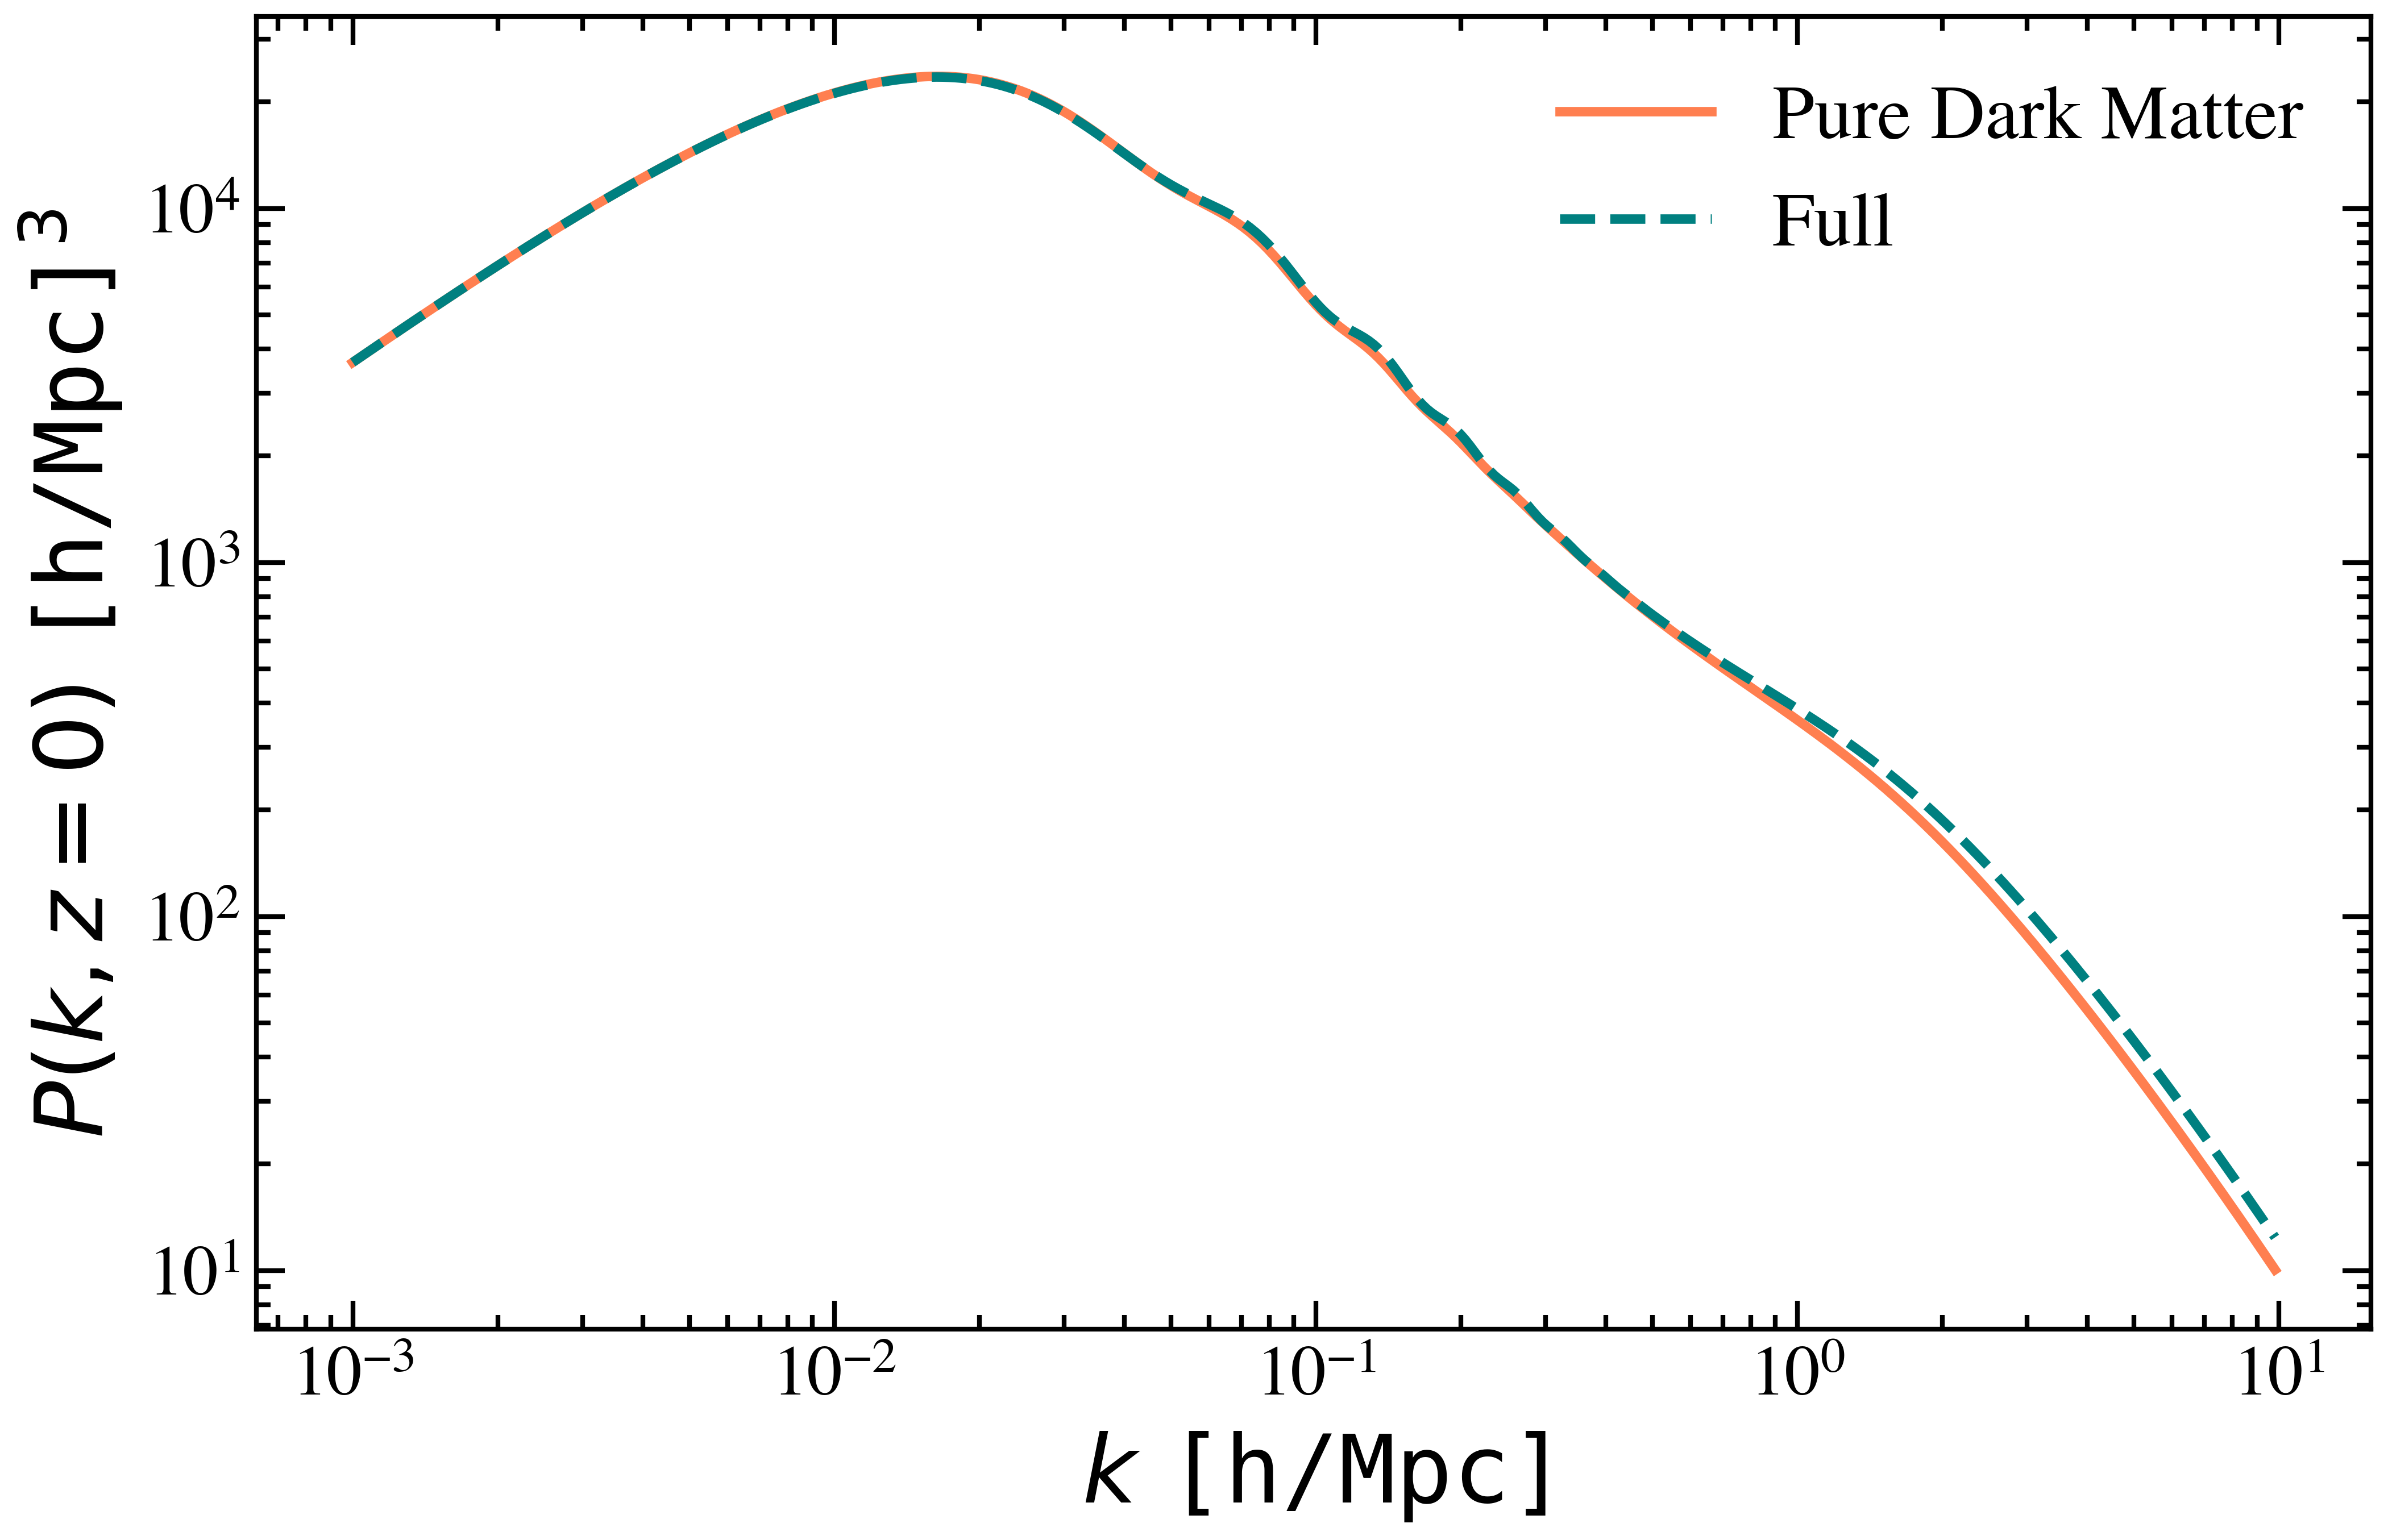

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), sharex = False, sharey= True)

ax.plot(k_modes, 10**Pk_nl[12:], '-', color='coral', lw=2.0, label= r'Pure Dark Matter')
ax.plot(k_modes, Pk_full, '--', color='teal', lw=2.0, label= r'Full')
ax.set_ylabel(r"$P(k, z=0) \ \mathtt{[h/Mpc]}^3$",fontsize=20)
ax.set_xlabel(r"$k \ \mathtt{[h/Mpc]}$",fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax.legend()
plt.show()

# 2) A bunch of parameters set

### Now, we'll proceed to emulate 100,000 spectra and record the computational timing for the calculations.
### Given the following dictionary:  

In [16]:
N_params = 100000

params_set_ds = {'omega_b': np.linspace(0.01865, 0.02625, N_params),
                 'omega_cdm': np.linspace(0.1, 0.255, N_params),
                 'h': np.linspace(0.64, 0.82, N_params),
                 'n_s': np.linspace(0.84, 1.1, N_params),
                 'S_8': np.linspace(0.6, 0.9, N_params),
                 'm_nu': np.linspace(0.0, 0.2, N_params),
                 'w': np.linspace(-1.3, -0.7, N_params),
                 'A': np.tile(0.0, N_params),
                 'z': np.linspace(0.0, 5.0, N_params)
                }

c_min_array = np.linspace(2.0, 4.0, N_params)
params_set_baryonic = {'omega_b': np.linspace(0.01865, 0.02625, N_params),
                       'omega_cdm': np.linspace(0.1, 0.255, N_params),
                       'h': np.linspace(0.64, 0.82, N_params),
                       'n_s': np.linspace(0.84, 1.1, N_params),
                       'S_8': np.linspace(0.6, 0.9, N_params),
                       'c_min': c_min_array,
                       'eta_0': 0.98 - (0.12*c_min_array),
                       'z': np.linspace(0.0, 5.0, N_params)
                      }

In [17]:
%%time
Pk_nl_array = nl_emu.predictions_np(params_set_ds) #log10(Pk_nl)

CPU times: user 12.9 s, sys: 5.1 s, total: 18 s
Wall time: 13 s


In [18]:
np.shape(Pk_nl_array)

(100000, 372)

In [19]:
%%time
Bk_array = baryonic_emu.predictions_np(params_set_baryonic) #log10(Bk)

CPU times: user 14 s, sys: 5.07 s, total: 19.1 s
Wall time: 13.1 s


In [20]:
np.shape(Bk_array)

(100000, 360)

In [21]:
Pk_full_array = 10.0**(Bk_array + Pk_nl_array[:,12:])

In [22]:
np.shape(Pk_full_array)

(100000, 360)

### Each emulation has been full computed in an impressive ~19 seconds!!!

## Finally, let's visualize a subset of 1000 full spectra with a plot.

In [23]:
import matplotlib.colorbar

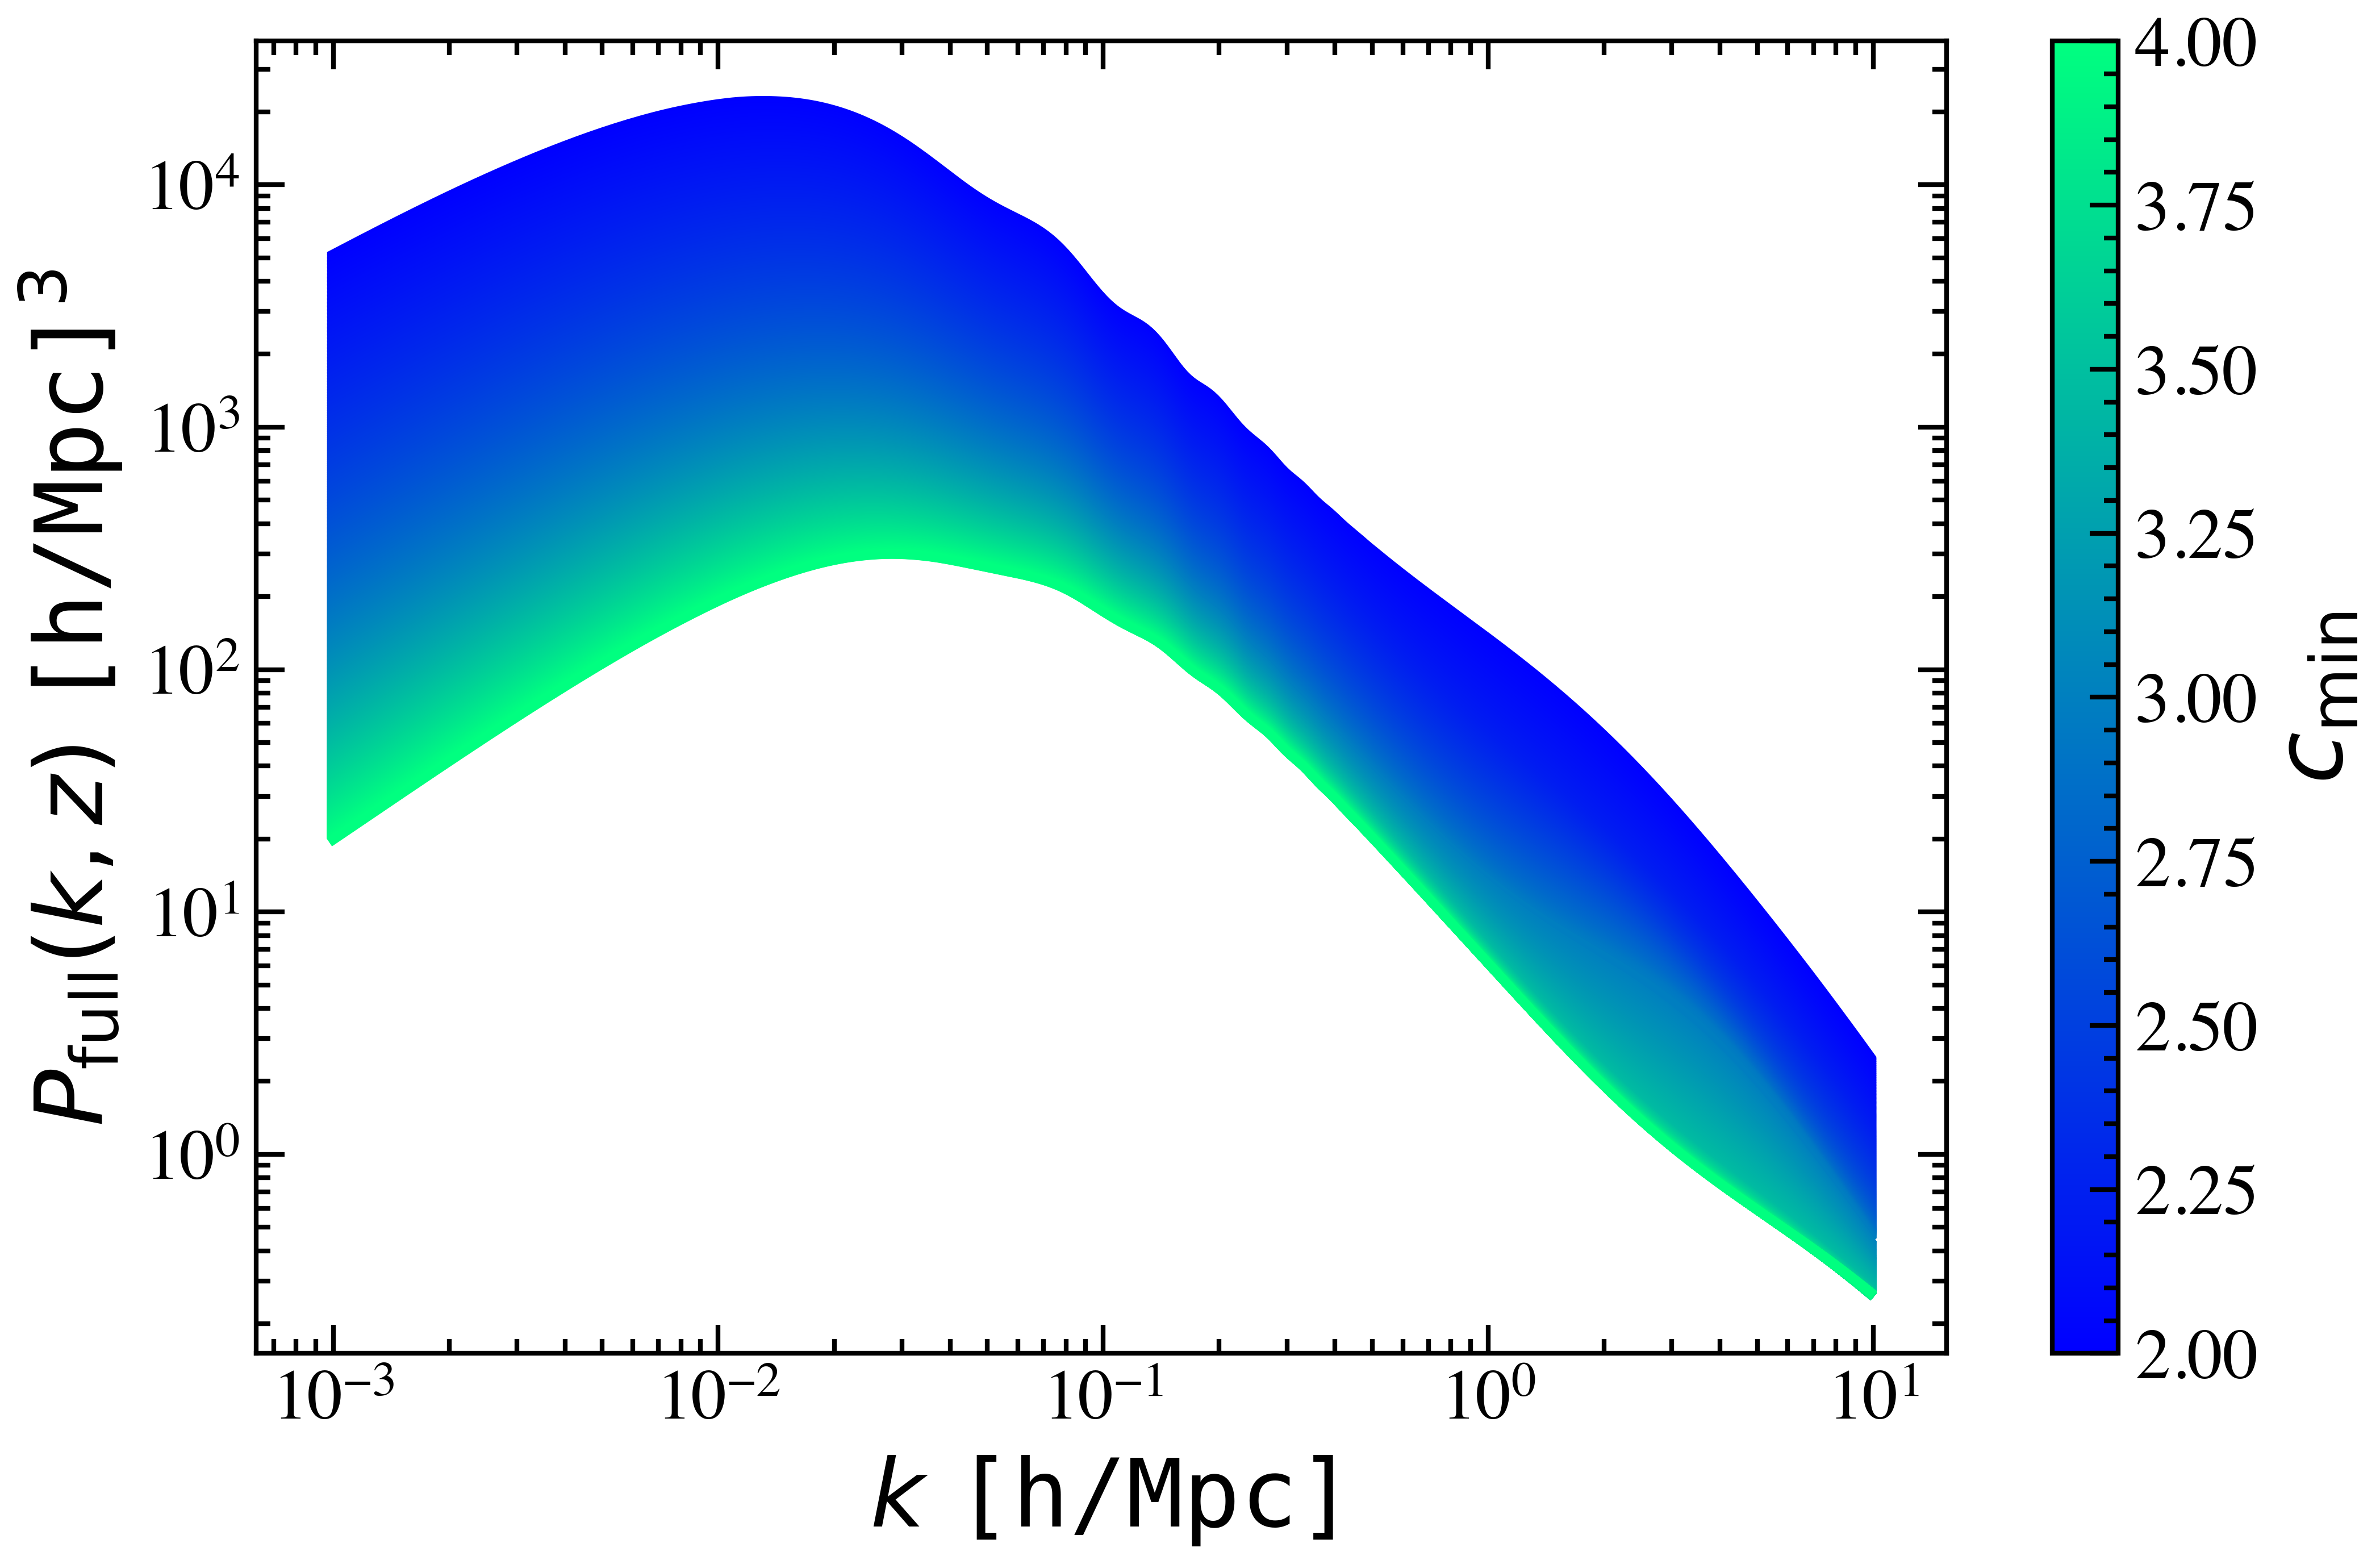

In [24]:
cmap = plt.get_cmap("winter")
  
fig, ax = plt.subplots(1, 1, figsize=(8, 5), sharex = False, sharey= True)

for param_name, ls, param in [("$c_{\\rm min}$", "-", params_set_baryonic['c_min'])]:
    cb_ax = matplotlib.colorbar.make_axes(ax, location='right')
    norm = matplotlib.colors.Normalize(vmin=param[0], vmax=param[-1])
    cb1 = matplotlib.colorbar.ColorbarBase(cb_ax[0], cmap=cmap, norm=norm, **cb_ax[1])

    cb1.set_label(param_name,fontsize=20)
    cb1.ax.tick_params(labelsize=15)
    for ii in range(1000):
        jj = ii*100
        _ = ax.plot(k_modes, Pk_full_array[jj], 
                                ls=ls, c=cmap(jj/len(param)))
        
ax.set_ylabel(r"$P_{\rm full}(k, z) \ \mathtt{[h/Mpc]}^3$",fontsize=20)
ax.set_xlabel(r"$k \ \mathtt{[h/Mpc]}$",fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)

plt.show()

#### End of the notebook.